In [ ]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

# --- Configuration ---
OFFLINE_DIR = "./offline_assets"
# 1. Model: Use the 1.1B TinyLlama model
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# 2. Task B Dataset: GSM8K
CODE_DATASET_NAME = "gsm8k"
CODE_DATASET_CONFIG = "main"

# Task A Dataset: MATH
MATH_DATASET_NAME = "qwedsacf/competition_math"

# # --- Create Directory ---
if not os.path.exists(OFFLINE_DIR):
    os.makedirs(OFFLINE_DIR)
    print(f"Created directory: {OFFLINE_DIR}")

# --- 1. Download Model and Tokenizer ---
print(f"--- Downloading Model: {MODEL_NAME} ---")
MODEL_PATH = os.path.join(OFFLINE_DIR, MODEL_NAME.replace("/", "_")) # Safer path name

# Download and save tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODEL_PATH)
print(f"Tokenizer saved to {MODEL_PATH}")

# Download and save model
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.save_pretrained(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


# --- 2. Download Task B: GSM8K ---
print(f"\n--- Downloading Dataset: {CODE_DATASET_NAME} ---")
GSM8K_PATH = os.path.join(OFFLINE_DIR, "gsm8k")

# For gsm8k, we will download both train and test splits.
gsm8k_dataset = load_dataset(CODE_DATASET_NAME, CODE_DATASET_CONFIG)
gsm8k_dataset.save_to_disk(GSM8K_PATH)
print(f"GSM8K dataset saved to {GSM8K_PATH}")


# --- 3. Download Task A: MATH ---
print(f"\n--- Downloading Dataset: {MATH_DATASET_NAME} ---")
MATH_PATH = os.path.join(OFFLINE_DIR, "hendrycks_math")

math_dataset = load_dataset(MATH_DATASET_NAME)
math_dataset.save_to_disk(MATH_PATH)
print(f"MATH dataset saved to {MATH_PATH}")

print("\n--- All assets downloaded and saved successfully. ---")
print(f"Please transfer the entire '{OFFLINE_DIR}' directory to your offline server.")

Created directory: ./offline_assets
--- Downloading Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0 ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer saved to ./offline_assets/TinyLlama_TinyLlama-1.1B-Chat-v1.0


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model saved to ./offline_assets/TinyLlama_TinyLlama-1.1B-Chat-v1.0

--- Downloading Dataset: gsm8k ---


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7473 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1319 [00:00<?, ? examples/s]

GSM8K dataset saved to ./offline_assets/gsm8k

--- Downloading Dataset: qwedsacf/competition_math ---


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12500 [00:00<?, ? examples/s]

MATH dataset saved to ./offline_assets/hendrycks_math

--- All assets downloaded and saved successfully. ---
Please transfer the entire './offline_assets' directory to your offline server.


In [ ]:
import torch
import json
import os
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from datasets import load_dataset, concatenate_datasets
from transformers.trainer_callback import TrainerCallback
from peft import LoraConfig, get_peft_model, PeftModel
from tqdm import tqdm
import warnings
from torch.utils.data import DataLoader
from torch.optim import AdamW

# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. Configuration ---
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Task B: GSM8K
CODE_DATASET_NAME = "gsm8k"
CODE_DATASET_CONFIG = "main"

# Task A: MATH
MATH_DATASET_NAME = "qwedsacf/competition_math"

RESULTS_DIR = "./drive/MyDrive/"

# 【Checkpoints】
# Task A Adapter (MATH)
TASK_A_ADAPTER_PATH = os.path.join(RESULTS_DIR, "math_adapter_llama_bf16")


# --- VRAM-Saving Config ---
MAX_SEQ_LENGTH = 2048
PER_DEVICE_BS = 64
GRAD_ACC_STEPS = 1

# --- Experiment Config ---
N_TRAIN_EXAMPLES = 4000
N_VAL_EXAMPLES = 400
TASK_A_EPOCHS = 2 # For Math
TASK_B_EPOCHS = 2 # For GSM8K

# --- 2. Utility Functions (Data Formatting) ---
def format_gsm8k(example):
    """Formats GSM8K data into a Llama-chat-style prompt."""
    question = example["question"]
    answer = example["answer"]

    text = (
        f"<s>[INST] You are a math expert. Solve the following math problem. "
        f"Show your work.\nProblem: {question} [/INST] "
        f"Solution: {answer}</s>"
    )
    return text

def format_math(example):
    """Formats MATH data into a Llama-chat-style prompt."""
    problem = example["problem"]
    solution = example["solution"]

    text = (
        f"<s>[INST] You are a math expert. Solve the following math problem. "
        f"Show your work.\nProblem: {problem} [/INST] "
        f"Solution: {solution}</s>"
    )
    return text

def filter_by_length(example, tokenizer, formatter):
    text = formatter(example)
    tokenized = tokenizer(text, max_length=MAX_SEQ_LENGTH + 1, truncation=False, padding=False)
    return len(tokenized['input_ids']) <= MAX_SEQ_LENGTH

def preprocess(example, tokenizer, formatter):
    text = formatter(example)
    tokenized = tokenizer(
        text,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding="max_length",
    )
    labels = tokenized["input_ids"].copy()
    inst_token_id = tokenizer.convert_tokens_to_ids("]")

    split_point = -1
    for i in range(len(tokenized["input_ids"]) - 1, -1, -1):
        if tokenized["input_ids"][i] == inst_token_id:
            split_point = i + 1
            break

    if split_point == -1:
        return {}

    for i in range(split_point):
        labels[i] = -100

    tokenized["labels"] = labels
    return tokenized

# --- 3. Model Loading ---

def get_model_and_tokenizer_base():
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        dtype=torch.bfloat16, # Changed to bfloat16
        device_map="auto",
        trust_remote_code=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    model.gradient_checkpointing_enable()
    return model, tokenizer

def get_lora_config():
    return LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

# --- 4. Main Experiment Logic ---
def main():
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    print(f"--- Loading Base Model & Tokenizer ---")
    base_model, tokenizer = get_model_and_tokenizer_base()

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # --- Load and Process Datasets ---
    print(f"\n--- Loading and Preprocessing Datasets (This may take a while) ---")

    # Task B: GSM8K
    print(f"Loading GSM8K...")
    raw_gsm8k = load_dataset(CODE_DATASET_NAME, CODE_DATASET_CONFIG)

    # Select N_TRAIN_EXAMPLES from 'train' split and N_VAL_EXAMPLES from 'test' split
    gsm8k_train = raw_gsm8k["train"].shuffle(seed=42).select(range(N_TRAIN_EXAMPLES))
    gsm8k_val = raw_gsm8k["test"].shuffle(seed=42).select(range(N_VAL_EXAMPLES))

    print(f"Tokenizing and filtering GSM8K...")
    gsm8k_train_tokenized = gsm8k_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_gsm8k),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_gsm8k),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    gsm8k_val_tokenized = gsm8k_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_gsm8k),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_gsm8k),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    print(f"GSM8K: {len(gsm8k_train_tokenized)} train, {len(gsm8k_val_tokenized)} val (after filtering)")

    # Task A: MATH
    raw_math = load_dataset(MATH_DATASET_NAME)
    total_math_samples_needed = N_TRAIN_EXAMPLES + N_VAL_EXAMPLES
    math_subset = raw_math["train"].shuffle(seed=42).select(range(total_math_samples_needed))
    val_size_fraction = N_VAL_EXAMPLES / total_math_samples_needed
    math_splits = math_subset.train_test_split(test_size=val_size_fraction, seed=42)
    math_train = math_splits["train"]
    math_val = math_splits["test"]

    print(f"Tokenizing and filtering MATH...")
    math_train_tokenized = math_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    math_val_tokenized = math_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    print(f"MATH: {len(math_train_tokenized)} train, {len(math_val_tokenized)} val (after filtering)")


    # --- Experiment 2: Sequential Training (CF) [MATH -> GSM8K] ---
    print(f"\n--- Starting Experiment 2: Sequential Training (CF) [MATH -> GSM8K] ---")

    lora_config = get_lora_config()
    seq_model = get_peft_model(base_model, lora_config)
    seq_model.print_trainable_parameters()

    seq_args_a = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "seq_training_A"),
        per_device_train_batch_size=PER_DEVICE_BS,
        gradient_accumulation_steps=GRAD_ACC_STEPS,
        num_train_epochs=TASK_A_EPOCHS,
        learning_rate=2e-4,
        logging_steps=10,
        save_strategy="no",
        report_to="none",
        gradient_checkpointing=True,
        bf16=True, # Enable BF16
    )

    seq_trainer_a = Trainer(
        model=seq_model,
        args=seq_args_a,
        train_dataset=math_train_tokenized,
        eval_dataset=math_val_tokenized,
        data_collator=data_collator,
    )

    seq_trainer_a.train()

    print(f"--- Phase 1 (MATH) training complete. Saving adapter to {TASK_A_ADAPTER_PATH} ---")
    seq_model.save_pretrained(TASK_A_ADAPTER_PATH)
    print("Adapter saved.")

    del seq_trainer_a
    torch.cuda.empty_cache()

     # --- Evaluate the "Task A Expert" model ---
    print("\n--- Evaluating Model after Phase 1 (Task A Expert) ---")
    eval_args = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "eval_temp"),
        per_device_eval_batch_size=PER_DEVICE_BS,
        report_to="none",
        gradient_checkpointing=True,
        bf16=True, # Enable BF16
    )

    eval_trainer = Trainer(
        model=seq_model,
        args=eval_args,
        data_collator=data_collator,
    )

    eval_gsm8k_phase1 = eval_trainer.evaluate(eval_dataset=gsm8k_val_tokenized)
    print(f"  > Task B (GSM8K) Val Loss: {eval_gsm8k_phase1['eval_loss']:.4f}")
    eval_math_phase1 = eval_trainer.evaluate(eval_dataset=math_val_tokenized)
    print(f"  > Task A (MATH) Val Loss: {eval_math_phase1['eval_loss']:.4f}")
    del eval_trainer, eval_args
    torch.cuda.empty_cache()

    # --- Phase 2: Train on GSM8K (Forgetting MATH happens here) ---
    print(f"\n  --- Phase 2: Training on Task B (GSM8K) ---")

    # Explicitly load the adapter for Phase 2 training as requested by the user
    print(f"--- Loading Task A adapter from {TASK_A_ADAPTER_PATH} for Phase 2 ---")
    seq_model = PeftModel.from_pretrained(base_model, TASK_A_ADAPTER_PATH, is_trainable=True)
    seq_model.print_trainable_parameters()

    history = {"steps": [], "gsm8k_loss": [], "math_loss": []}

    # Custom Trainer to log forgetting
    class ForgettingTrackerCallback(TrainerCallback):
      def __init__(self, gsm8k_val, math_val, history_log, start_metrics):
          super().__init__()
          self.gsm8k_eval_dataset = gsm8k_val
          self.math_eval_dataset = math_val
          self.history = history_log
          self.trainer = None
          self.is_evaluating = False

          # Initial State (Step 0)
          self.history["steps"].append(0)
          self.history["gsm8k_loss"].append(start_metrics['gsm8k_loss'])
          self.history["math_loss"].append(start_metrics['math_loss'])
          print("Initializing ForgettingTrackerCallback with starting metrics.")

      def set_trainer(self, trainer):
          self.trainer = trainer

      def on_log(self, args, state, control, **kwargs):
          if self.is_evaluating:
              return
          self.is_evaluating = True

          if not self.trainer:
              self.is_evaluating = False
              return

          print(f"\n--- Custom Eval at Step {state.global_step} ---")
          print("Evaluating on Task B (GSM8K)...")
          gsm8k_metrics = self.trainer.evaluate(eval_dataset=self.gsm8k_eval_dataset)
          gsm8k_loss = gsm8k_metrics['eval_loss']
          print(f"  > Step {state.global_step} - GSM8K Val Loss: {gsm8k_loss:.4f} (LEARNING?)")

          print("Evaluating on Task A (MATH)...")
          math_metrics = self.trainer.evaluate(eval_dataset=self.math_eval_dataset)
          math_loss = math_metrics['eval_loss']
          print(f"  > Step {state.global_step} - MATH Val Loss: {math_loss:.4f} (FORGETTING?)")

          self.history["steps"].append(state.global_step)
          self.history["gsm8k_loss"].append(gsm8k_loss)
          self.history["math_loss"].append(math_loss)

          self.is_evaluating = False
          self.trainer.model.train()


    seq_args_b = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "seq_training_B"),
        per_device_train_batch_size=PER_DEVICE_BS,
        gradient_accumulation_steps=GRAD_ACC_STEPS,
        num_train_epochs=TASK_B_EPOCHS,
        learning_rate=2e-4, # Updated learning rate
        logging_steps=10,
        save_strategy="no",
        report_to=[],
        gradient_checkpointing=True,
        bf16=True, # Enable BF16
    )
    seq_model.enable_input_require_grads()

    tracker_callback = ForgettingTrackerCallback(
        gsm8k_val=gsm8k_val_tokenized,
        math_val=math_val_tokenized,
        history_log=history,
        start_metrics={
            'gsm8k_loss': eval_gsm8k_phase1['eval_loss'],
            'math_loss': eval_math_phase1['eval_loss'],
        }
    )

    seq_trainer_b = Trainer(
        model=seq_model,
        args=seq_args_b,
        train_dataset=gsm8k_train_tokenized,
        eval_dataset=gsm8k_val_tokenized,
        data_collator=data_collator,
        callbacks=[tracker_callback]
    )

    tracker_callback.set_trainer(seq_trainer_b)
    seq_trainer_b.train()

    # --- 5. Plot Results ---
    print("\n--- Saving History Data and Generating Plot ---")

    history_filename = os.path.join(RESULTS_DIR, "forgetting_history_MATH_to_GSM8K_bf16.json")
    try:
        with open(history_filename, 'w') as f:
            json.dump(history, f, indent=4)
        print(f"History data saved to {history_filename}")
    except Exception as e:
        print(f"Error saving history to JSON: {e}")

    plt.figure(figsize=(12, 6))
    plt.plot(history["steps"], history["gsm8k_loss"], 'o-', label="Task B (GSM8K) Loss", color="blue")
    plt.plot(history["steps"], history["math_loss"], 'o-', label="Task A (MATH) Loss", color="red")

    plt.title(f"Catastrophic Forgetting: MATH -> GSM8K (Model: {MODEL_NAME} BF16 LoRA)", fontsize=16)
    plt.xlabel(f"Training Steps on Task B (GSM8K) (Total Epochs: {TASK_B_EPOCHS})", fontsize=14)
    plt.ylabel("Validation Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()

    plot_filename = os.path.join(RESULTS_DIR, "sequential_forgetting_curve_MATH_to_GSM8K_bf16.png")
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")

    try:
        from google.colab import files
        plt.show()
    except ImportError:
        print("Not in Colab, plot saved to file.")

if __name__ == "__main__":
    if not torch.cuda.is_available():
        print("ERROR: This experiment requires a GPU. Check Colab runtime type.")
    else:
        print(f"INFO: Running on GPU. VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        if torch.cuda.get_device_properties(0).total_memory / 1e9 < 11:
            print("WARNING: VRAM is less than 11GB. You may hit OOM errors. Try lowering MAX_SEQ_LENGTH.")
    main()

INFO: Running on GPU. VRAM: 85.17 GB
--- Loading Base Model & Tokenizer ---

--- Loading and Preprocessing Datasets (This may take a while) ---
Loading GSM8K...
Tokenizing and filtering GSM8K...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

GSM8K: 4000 train, 400 val (after filtering)
Tokenizing and filtering MATH...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Filter:   0%|          | 0/399 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


MATH: 3994 train, 399 val (after filtering)

--- Starting Experiment 2: Sequential Training (CF) [MATH -> GSM8K] ---
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,1.421600
20,1.194000
30,1.072800
40,1.045400
50,1.033400
60,1.015000
70,1.031100
80,0.979900
90,0.993200
100,1.004100


--- Phase 1 (MATH) training complete. Saving adapter to ./drive/MyDrive/math_adapter_llama_bf16 ---


The model is already on multiple devices. Skipping the move to device specified in `args`.


Adapter saved.

--- Evaluating Model after Phase 1 (Task A Expert) ---


  > Task B (GSM8K) Val Loss: 1.3594


The model is already on multiple devices. Skipping the move to device specified in `args`.


  > Task A (MATH) Val Loss: 1.0142

  --- Phase 2: Training on Task B (GSM8K) ---
--- Loading Task A adapter from ./drive/MyDrive/math_adapter_llama_bf16 for Phase 2 ---
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
Initializing ForgettingTrackerCallback with starting metrics.


Step,Training Loss,Validation Loss
10,1.166800,1.122084
20,0.985100,0.969549



--- Custom Eval at Step 10 ---
Evaluating on Task B (GSM8K)...
  > Step 10 - GSM8K Val Loss: 1.0435 (LEARNING?)
Evaluating on Task A (MATH)...
  > Step 10 - MATH Val Loss: 1.1221 (FORGETTING?)

--- Custom Eval at Step 20 ---
Evaluating on Task B (GSM8K)...
  > Step 20 - GSM8K Val Loss: 0.9695 (LEARNING?)
Evaluating on Task A (MATH)...


成功从 ./drive/MyDrive/forgetting_history_MATH_to_GSM8K_fp32.json 加载历史数据。
正在生成新绘图...
绘图已成功保存到 ./drive/MyDrive/replotted_forgetting_curve_MATH_to_GSM8K.png


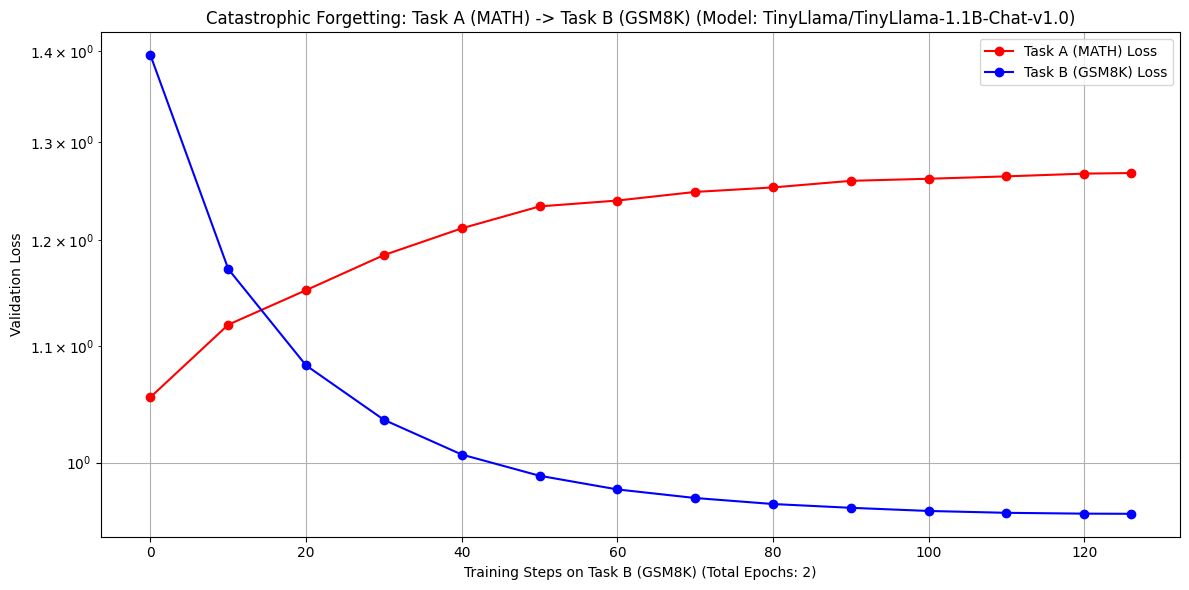

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# --- 配置 ---
# Ensure this matches the RESULTS_DIR in the training script
RESULTS_DIR = "./drive/MyDrive/"
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
TASK_B_EPOCHS = 2

# 输入和输出文件名
history_filename = os.path.join(RESULTS_DIR, "forgetting_history_MATH_to_GSM8K_bf16.json")
output_plot_filename = os.path.join(RESULTS_DIR, "replotted_forgetting_curve_MATH_to_GSM8K_bf16.png")

def replot_from_json(json_path, output_path):
    """
    从JSON文件加载历史数据并重新生成绘图。
    """
    # --- 1. 加载数据 ---
    if not os.path.exists(json_path):
        print(f"错误：找不到输入文件 {json_path}")
        print(f"请确保先运行训练脚本，并且 RESULTS_DIR 设置正确。当前路径: {os.path.abspath(json_path)}")
        return

    try:
        with open(json_path, 'r') as f:
            history = json.load(f)
        print(f"成功从 {json_path} 加载历史数据。")
    except Exception as e:
        print(f"错误：无法读取或解析JSON文件：{e}")
        return

    # 验证数据完整性
    if not all(key in history for key in ["steps", "gsm8k_loss", "math_loss"]):
        print("错误：JSON文件缺少必要的键 ('steps', 'gsm8k_loss', 'math_loss')。")
        return

    # --- 2. 重新绘图 ---
    print("正在生成新绘图...")
    plt.figure(figsize=(12, 6))

    # Task A 是 MATH (红色)
    plt.plot(history["steps"], history["math_loss"], 'o-', label="Task A (MATH) Loss", color="red")
    # Task B 是 GSM8K (蓝色)
    plt.plot(history["steps"], history["gsm8k_loss"], 'o-', label="Task B (GSM8K) Loss", color="blue")

    plt.title(f"Catastrophic Forgetting: Task A (MATH) -> Task B (GSM8K) (Model: {MODEL_NAME} BF16)", fontsize=16)
    plt.xlabel(f"Training Steps on Task B (GSM8K) (Total Epochs: {TASK_B_EPOCHS})", fontsize=14)
    plt.ylabel("Validation Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()

    # --- 3. 保存绘图 ---
    try:
        plt.savefig(output_path)
        print(f"绘图已成功保存到 {output_path}")
        plt.show()
    except Exception as e:
        print(f"错误：无法保存绘图：{e}")


if __name__ == "__main__":
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    replot_from_json(history_filename, output_plot_filename)